# Minimize Free Energy

Here we explore the states which minimize the free energy,
$$ E = <H> - T S = \text{Tr}(\rho H) + T \text{Tr}(\rho \ln \rho)$$

In [1]:
from Define_Paulis import I, X, Y, Z, Mdot, bkt
import numpy as np
import scipy.linalg as ln

## Directly minimize the density matrix

Let us start by taking $\rho$ to be diagonal in the eigenbasis of H.
\begin{equation}
\rho = \begin{pmatrix} e^{x_1} & 0 & 0 & 0 \\ 0 & e^{x_2} & 0 & 0 \\ 0 & 0 & e^{x_3} & 0 \\ 0 & 0 & 0 &  \ddots  \end{pmatrix}
\end{equation}
so that $$ \text{Tr}(\rho H) = e^{x_1} E_0 + e^{x_2} E_1 + e^{x_3} E_2 + \ldots$$
and 
$$ \text{Tr}(\rho \ln \rho) = e^{x_1} x_1 + e^{x_1} x_2 + e^{x_1} x_3 + \ldots $$

We search for minima for each parameter, 
$$ 0 = \frac{d}{dx_n}F = e^{x_n}E_0 + T(x_n+1)e^{x_n} $$
$$ x_n = -\frac{E_n}{T} - 1$$
Since we have neglected normalization the $-1$ is meaningless.  

Let's check this,


In [51]:
H = Z(0,2) + Z(1,2) + 0.3*Mdot([X(0,2),X(1,2)])

e,y = ln.eig(H)
arg = np.argsort(e)
psi = np.conjugate(np.transpose(y))
    


def ketbra(psia,psib):
    out = [[0 for i in range(len(psia))] for j in range(len(psib))]
    for i in range(len(psia)):
        for j in range(len(psib)):
            out[i][j] = psia[i]*np.conjugate( psib[j] )
    return np.array(out)
            
def S(rho):
    e,y = ln.eig(rho)
    s = -sum([np.round( (e[n]+10**-28)*np.log(e[n]+10**(-28)) , 8) for n in range(len(e))])
    return s

def FreeE(T,H,rho):
    #print('H: ',np.trace(Mdot([H,rho])))
    #print('S: ', + T*S(rho))
    return np.trace(Mdot([H,rho])) - T*S(rho)
    

def rho(a,b,c,d):
    rho0 = a*ketbra(psi[arg[0]],psi[arg[0]]) + b*ketbra(psi[arg[1]],psi[arg[1]]) + c*ketbra(psi[arg[2]],psi[arg[2]]) + d*ketbra(psi[arg[3]],psi[arg[3]])
    rho0 = rho0/np.trace(rho0)
    return rho0


In [23]:
T=2.0
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
rho0 = rho(a,b,c,d)

FreeE(T,H,rho0)



(-3.2722345306848+0j)

In [24]:
FEl = []
drl = []
T=2.0
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
for dri in range(0,90):
    dr = dri*0.1 - a
    rho0 = rho(abs(a+dr),abs(b),abs(c),abs(d))
    FE = FreeE(T,H,rho0)
    FEl.append(FE)
    drl.append(dr)

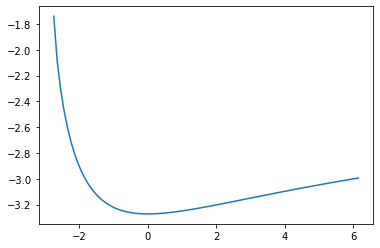

In [25]:
import matplotlib.pyplot as plt

plt.plot(drl,FEl)


This seems to be the correct minimum. 

## Starting from entropy

Now let us start in the entropic state,
\begin{equation}
\rho_0 = e^{-E_0/T}|00><00| + e^{-E_1/T}|10><10| + e^{-E_2/T}|01><01| + e^{-E_3/T}|11><11| + 
\end{equation}
then we apply a basis rotation $U$ so that $$ U^{\dagger}\rho U = e^{-E_0/T}|E_0><E_0| + e^{-E_1/T}|E_1><E_1| + e^{-E_2/T}|E_2><E_2| + e^{-E_3/T}|E_3><E_3| $$


In [26]:


def rho0(a,b,c,d):
    rho = [[0 for i in range(4)] for j in range(4)]
    rho[arg[0]][arg[0]] = a
    rho[arg[1]][arg[1]] = b
    rho[arg[2]][arg[2]] = c
    rho[arg[3]][arg[3]] = d
    rho = rho/np.trace(rho)
    return rho


T=2.0
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )

rhop = Mdot([np.conjugate(np.transpose(psi)),rho0(a,b,c,d),psi])


print("Entropt is the same: ", S(rho0(a,b,c,d)) - S(rho(a,b,c,d)))

print("density matrix after rotation: ",np.amax(np.abs( rhop - rho(a,b,c,d) )) )


Entropt is the same:  0j
density matrix after rotation:  2.7755575615628914e-17


## Generate entropy from measurments

Starting with the quantum system in the state 
$$ \rho_i = |00> <00| $$ 
we perform a unitary operation to take the state to 
$$ \rho_v = V^{\dagger}\rho V = (e^{-E_0/2T}|00> + e^{-E_1/2T}|10> + e^{-E_2/2T} |01> + e^{-E_3/2T}|11>)(e^{-E_0/2T}<00| + e^{-E_1/2T}<10| + e^{-E_2/2T} <01| + e^{-E_3/2T}<11|)$$ 
we then measure the system 
$$ \rho_0 = \sum_s |s><s|\rho_v|s><s| = e^{-E_0/T} |00><00| + e^{-E_1/T} |10><10| + e^{-E_2/T} |01><01| + |e^{-E_3/T} |11><11|  $$
Then we perform a unitary rotation to get it in the eigenbasis
$$ \rho =  U^{\dagger}\rho U = e^{-E_0/T} |E_0><E_0| + e^{-E_1/T}|E_1><E_1| + e^{-E_2/T} |E_2><E_2| + e^{-E_3/T} |E_3><E_3|$$

In [27]:
def M(il,N):
    Ml = [I(N)]
    for i in il:  
        M2 = []
        for M in Ml:
            Ma = 1/2*Mdot([M,(I(N)+Z(i,N))])
            Mb = 1/2*Mdot([M,(I(N)-Z(i,N))])
            M2.append(Ma)
            M2.append(Mb)
        Ml = M2
    return Ml

def Meas(rho,il):
    N = int(np.log2(len(rho)))
    ml = M(il,N)
    rho_new = 0*rho
    for m in ml:
        rho_new = rho_new + Mdot([m,rho,m])
    return rho_new

In [28]:
N = np.sqrt(a + b + c + d)
a2 = np.sqrt(a)/N
b2 = np.sqrt(b)/N
c2 = np.sqrt(c)/N
d2 = np.sqrt(d)/N

# This only works because of symmetry in the eigenvalues
V0 = np.array([a2,b2,c2,d2])
V1 = np.array([b2,-a2,0,0])/np.sqrt(b2**2+a2**2)
V2 = np.array([0,0,d2,-c2])/np.sqrt(d2**2+c2**2)
V3 = np.array([-c2,-d2,a2,b2])

V0 = np.array([d2,a2,c2,b2])
V1 = np.array([a2,-d2,0,0])/np.sqrt(d2**2+a2**2)
V2 = np.array([0,0,b2,-c2])/np.sqrt(b2**2+c2**2)
V3 = np.array([-c2,-b2,d2,a2])

V = [V3,V0,V2,V1]
Vd = np.conjugate(np.transpose(V))


Mdot([Vd,V])

Mdot([Vd,[1,0,0,0]])


rhoi = rho0(1,0,0,0)
rhov = Mdot([Vd,rhoi,V])
rho00 = Meas(rhov,[0,1,2,3])
rhop = Mdot([np.conjugate(np.transpose(psi)),rho00,psi])

print("Entropt after measurment: ", S(rho00) - S(rho(a,b,c,d)))
print("Final density matrix: ",np.amax(np.abs( rhop - rho(a,b,c,d) )) )

Entropt after measurment:  0j
Final density matrix:  2.7755575615628914e-17


# Varriational U and V

What we would really like is for both $V$ and $U$ to be unknown.  We then find both $V$ and $U$ variationally.  I suspect that as long as you get the same enetropy when measuring that state after applying $V$, the specific from of $V$ is not important.  We will define $V$ with only a single variational parameter $V(S)$ which corresponds to the amount of entropy that will be generated.  
$$ V = \prod_{i=0}^j \hat{H}_i\hat{R}_{Hj}(\phi)$$
such that 
$$S = j \ln 2 + \cos(\phi/2)^2 \ln{\cos(\phi/2)^2} + \sin(\phi/2)^2 \ln{\sin(\phi/2)^2}$$
where $\hat{H}_i$ is a Hadamard gate on qubit $i$ and 
$$ \hat{R}_{Hj}(\phi) = Z_j(\cos(\phi/2)I - i\sin(\phi/2)Y_j) $$

In [60]:
import scipy.optimize as op

def Hd(i,N):
    return 1/np.sqrt(2)*(Z(i,N) + X(i,N))

def RH(theta,i,N):
    return Mdot([Z(i,N),np.cos(theta/2)*I(N) - 1j*np.sin(theta/2)*Y(i,N)])


def f(x,S):
    dx = 10**(-15)
    return -np.cos(x/2)**2 * np.log(np.cos(x/2)**2 + dx) - np.sin(x/2)**2 * np.log(np.sin(x/2)**2 + dx) - S

def V(S,N):
    j = int(S/np.log(2))
    if j >= N:
        raise NameError("An entropy of "+str(S)+" requires at least "+str(j+1)+" qubits.")
    dS = S - j*np.log(2)
    phi = op.brentq(f,0,np.pi/2, args = (dS))
    vout = I(N)
    for i in range(j):
        vout = Mdot([Hd(i,N),vout])
    vout = Mdot([RH(phi,j,N),vout])
    return vout



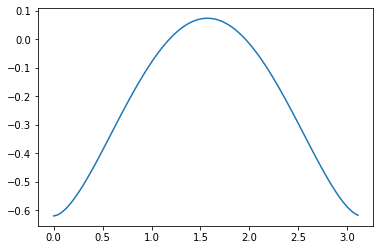

In [62]:
St = 1.312698
j = int(St/np.log(2))
dS = St - j*np.log(2)
il = [i*np.pi/(100) for i in range(0,100)]
fl = [f(i*np.pi/(100),dS) for i in range(0,100)]

plt.plot(il,fl)

In [64]:
N=2
Sin = 1.312698
rhoi = rho0(1,0,0,0)
rhov = Mdot([np.conjugate(np.transpose(V(Sin,N))),rhoi,V(Sin,N)])
rho00 = Meas(rhov,[0,1,2,3])

S(rho00)

(1.312698-0j)

For $U$ we will try the Hardware efficient ansatz.  

In [65]:
def Ry(theta,i,N):
    return np.cos(theta/2)*I(N) - 1j*np.sin(theta/2)*Y(i,N)

def Cx(i,j,N):
    return 1/2*( I(N) + Z(i,N) + X(j,N) - Mdot([Z(i,N),X(j,N)]) )


def U(Phi):
    T = len(Phi)
    N = len(Phi[0])
    uout = I(N)
    for t in range(T):
        for i in range(N):
            phi = Phi[t][i]
            uout = Mdot([Ry(phi,i,N),uout])
        for i in range(0,N,2):
            uout = Mdot([Cx(i,i+1,N),uout])
        for i in range(1,N,2):
            uout = Mdot([Cx(i,i+1,N),uout])
    return uout

In [66]:
N=2
Sin = (0.999)*2*np.log(2)
Phi = [[0.3,0.2],[0.5,0.1],[0.3,0.7]]

def rhof(Sin,Phi):
    N = len(Phi[0])
    rhoi = rho0(1,0,0,0)
    rhov = Mdot([np.conjugate(np.transpose(V(Sin,N))),rhoi,V(Sin,N)])
    rho00 = Meas(rhov,[0,1,2,3])
    rhop = Mdot([np.conjugate(np.transpose(U(Phi))),rho00,U(Phi)])
    return rhop

rhop = rhof(Sin,Phi)

FreeE(0.0,H,rhop)

(0.017612836732944837+0j)

In [67]:
def enforce_bounds(S,Smin,Smax):
    if S < Smin:
        S = Smin
    if S > Smax:
        S = Smax
    return S

# Minimize

In [68]:

def SPSA(T,S0,phi0,k_max):
    beta = 0.201
    A = 10
    a = 0.05
    gamma = 0.101
    c = 0.4
    np.random.seed(10)
    
    #Initalization
    k = 0
    Nt = len(phi0)
    N = len(phi0[0])
    max_S = 0.999*N*np.log(2)
    phi_k = np.array(phi0)
    S_k = S0
    E_l = []
    k_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for t in range(Nt):
            for q in range(N):
                Delta_k[t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta S
        Delta_Sk =  1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        S_k_A = S_k + c_k*Delta_Sk
        S_k_B = S_k - c_k*Delta_Sk
        S_k_A = enforce_bounds(S_k_A, 0, max_S)
        S_k_B = enforce_bounds(S_k_B, 0, max_S)
        
        #Find rho 
        rho_A = rhof(S_k_A,phi_k_A)
        rho_B = rhof(S_k_B,phi_k_B)
            
        #Find Free Energy    
        E_A = FreeE(T,H,rho_A)
        E_B = FreeE(T,H,rho_B)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_Sk = g * Delta_Sk
        S_k = S_k - a_k * g_Sk
        S_k = enforce_bounds(S_k, 0, max_S)
        
        #Find new rho
        rho = rhof(S_k,phi_k)
        
        #Find new Free Energy
        E = FreeE(T,H,rho)
        
        print(k,S_k,E)
        E_l.append(E)
        k_l.append(k)

    return E_l,k_l,S_k,phi_k

In [81]:
S0 = (0.0)*2*np.log(2)
phi0 = [[0.3,0.2],[0.5,0.1],[0.3,0.7],[1.2,0.9]]
#phi0 = [[0.3,0.2],[-0.5,0.1],[0.3,0.7],[0.1,0.8],[0.3,0.2],[0.3,0.3],[-0.2,0.1]]

T = 2.5
El,kl,Sf,phif = SPSA(T, S0, phi0, 300)

0 0.03223423879517739 (1.0386201828024315+0j)
1 0.16207693492805703 (-0.02503473760986885+0j)
2 0.15640399866943244 (-0.02535136063795823+0j)
3 0.2172804929465355 (-0.252013056446845+0j)
4 0.26893377861727386 (-0.3725122913947531+0j)
5 0.34838930569338517 (-0.6369833096743719+0j)
6 0.3358798936467549 (-0.6545572707393694+0j)
7 0.3631001967485925 (-0.6421712929358346+0j)
8 0.42623576504776345 (-0.7598263221725161+0j)
9 0.48394168260952064 (-0.872826850412904+0j)
10 0.45780427514818556 (-0.9373870312815319+0j)
11 0.5895083387978972 (-1.7912209379029123+0j)
12 0.5553333276521935 (-1.896502959027277+0j)
13 0.616965496254208 (-1.97774279291214+0j)
14 0.634878432781062 (-1.958212595630003+0j)
15 0.6016533331154621 (-2.084432757723363+0j)
16 0.6519682717736104 (-2.0926903917373623+0j)
17 0.6556953055039609 (-2.081008653684043+0j)
18 0.6765275288386394 (-2.022531395094405+0j)
19 0.7042945888089226 (-1.8750551946011615+0j)
20 0.7258797999962547 (-1.9309050954835674+0j)
21 0.7266291500333065 (-1

177 1.3849080667587708 (-3.51367885643308+0j)
178 1.3849080667587708 (-3.5136766882072092+0j)
179 1.3849080667587708 (-3.513790379755391+0j)
180 1.38210622341845 (-3.5448608102807335+0j)
181 1.384131963246376 (-3.5247538237866642+0j)
182 1.3849080667587708 (-3.514003472727583+0j)
183 1.3849080667587708 (-3.514263980819409+0j)
184 1.3849080667587708 (-3.514261815473874+0j)
185 1.3849080667587708 (-3.5141715259423565+0j)
186 1.3815744751247112 (-3.549976799857206+0j)
187 1.3849080667587708 (-3.51447733658902+0j)
188 1.3849080667587708 (-3.5144209863330946+0j)
189 1.3849080667587708 (-3.5145067710251094+0j)
190 1.3849080667587708 (-3.5146713695274707+0j)
191 1.3849080667587708 (-3.5147751525728785+0j)
192 1.3849080667587708 (-3.5149311026421337+0j)
193 1.384754344331321 (-3.5173955967834507+0j)
194 1.3849080667587708 (-3.514917748108349+0j)
195 1.3849080667587708 (-3.5152047169966343+0j)
196 1.3814122894240217 (-3.5531390657139337+0j)
197 1.3780781005975264 (-3.5747123115025663+0j)
198 1.

Let's check how this compares to the exact solution.

(-4.0, 0.0)

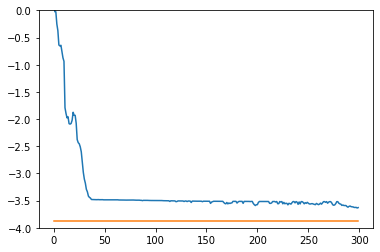

In [82]:
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
rhop = rho(a,b,c,d)


Ep = FreeE(T,H,rhop)
Epl = [Ep for k in kl]

plt.plot(kl,El)
plt.plot(kl,Epl)
plt.ylim(-4.0,0.0)

In [83]:
print( FreeE(T,H,rhop) )
print( FreeE(T,H,rhof(Sf,phif) ) )
print('dE = ', FreeE(T,H,rhop) - FreeE(T,H,rhof(Sf,phif) ) )
print('dE/E = ', (FreeE(T,H,rhop) - FreeE(T,H,rhof(Sf,phif)))/FreeE(T,H,rhop)  )

(-3.8717193280876407+0j)
(-3.628454584218148+0j)
dE =  (-0.2432647438694926+0j)
dE/E =  (0.06283119287720901-0j)


In [84]:
print( S(rhop) )
print( Sf )
print( S(rhof(Sf,phif)) )

(1.2330516599999999-0j)
1.367972530922635
(1.3679725399999998-0j)


In [85]:
print( np.trace(Mdot([rhop,H])) )
print( np.trace(Mdot([rhof(Sf,phif),H])) )

(-0.7890901780876409+0j)
(-0.2085232342181486+0j)
